In [1]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import string
from string import *
import pymongo
from collections import Counter

Using TensorFlow backend.


In [2]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [78]:
soup_recipes = []
for recipe in recipes_coll.find():
    if recipe['category']['lvl_2'] in ['Soup', 'Stews', 'Chili']:
        soup_recipes.append(recipe)
len(soup_recipes)

862

In [68]:
recipes = list(recipes_coll.find())
ingredients = Counter()
for recipe in recipes:
    for ing in recipe['ingredients'].keys():
        ingredients[ing] += 1
print('Number of unique ingredients :', len(ingredients))

Number of unique ingredients : 2143


In [76]:
common_ingredients = []
for item, count in ingredients.most_common():
    if count > 4:
        common_ingredients.append(item)
print('Number of common ingredients :', len(common_ingredients))

Number of common ingredients : 449


In [21]:
def create_labels(recipes):
    labels = []
    for recipe in recipes:
        labels.append(recipe['category']['lvl_2'])
    return labels

In [72]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

In [79]:
soup_df = create_dataframe(soup_recipes, cutoff=5)

In [81]:
soup_df.shape

(862, 240)

In [11]:
n_features = df.shape[1]
model3 = Sequential()
model3.add(Dense(300,  activation='relu', input_shape=(n_features,)))
model3.add(Dense(100,  activation='relu'))
model3.add(Dense(30,  activation='relu'))
model3.add(Dense(10,  activation='relu'))
model3.add(Dense(3,    activation='linear', name="bottleneck"))
model3.add(Dense(10,  activation='relu'))
model3.add(Dense(30,  activation='relu'))
model3.add(Dense(100,  activation='relu'))
model3.add(Dense(300,  activation='relu'))
model3.add(Dense(n_features,  activation='linear'))
model3.compile(loss='mean_squared_error', optimizer = 'adam')

In [12]:
X = df.values
means = np.mean(df, axis=0)
stds = np.std(df, axis=0)
df_scaled = (df - means) / stds
X_scaled = df_scaled.values

In [22]:
y = create_labels(recipes)

In [14]:
history = model3.fit(X_scaled, X_scaled, batch_size=60, epochs=100, verbose=None)

In [15]:
encoder3D = Model(model3.input, model3.get_layer('bottleneck').output)
z_enc = encoder3D.predict(X_scaled)

IndexError: index 2 is out of bounds for axis 1 with size 2

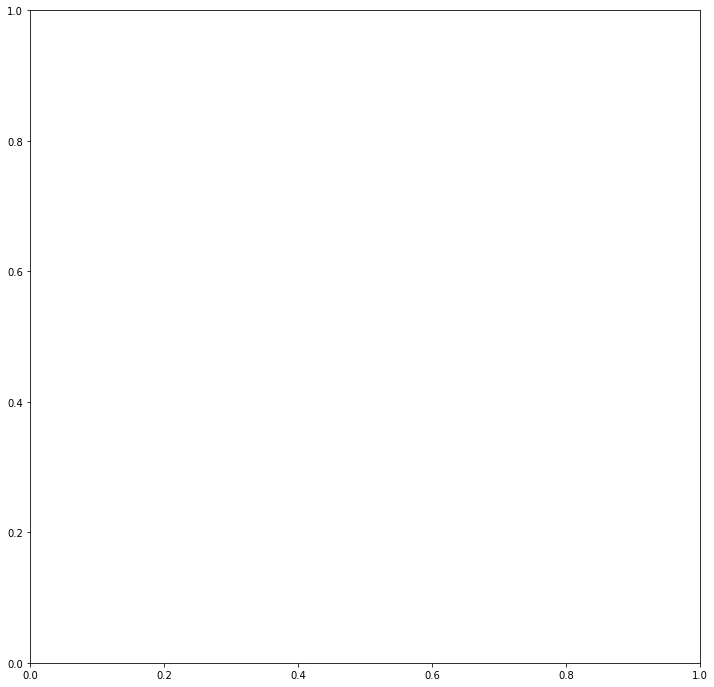

In [51]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))

mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
mean_2 = np.mean(z_enc[:,2])
std_2 = np.std(z_enc[:,2])
color = [cm.jet((val-(mean_2)) / (3*std_2) + 0.5) for val in z_enc[:,2]]
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=colors, s=75, alpha=0.8)
ax.set_yticklabels([])
ax.set_xticklabels([])

#ax.set_xlim(left=-20, right=20)
#ax.set_ylim(bottom=-20, top=20)


In [46]:
model2 = Sequential()
model2.add(Dense(300,  activation='relu', input_shape=(n_features,)))
model2.add(Dense(100,  activation='relu'))
model2.add(Dense(30,  activation='relu'))
model2.add(Dense(10,  activation='relu'))
model2.add(Dense(2,    activation='linear', name="bottleneck"))
model2.add(Dense(10,  activation='relu'))
model2.add(Dense(30,  activation='relu'))
model2.add(Dense(100,  activation='relu'))
model2.add(Dense(300,  activation='relu'))
model2.add(Dense(n_features,  activation='linear'))
model2.compile(loss='mean_squared_error', optimizer = 'adam')

In [55]:
history = model2.fit(X_scaled, X_scaled, batch_size=60, epochs=1000, verbose=None)

(-45, 25)

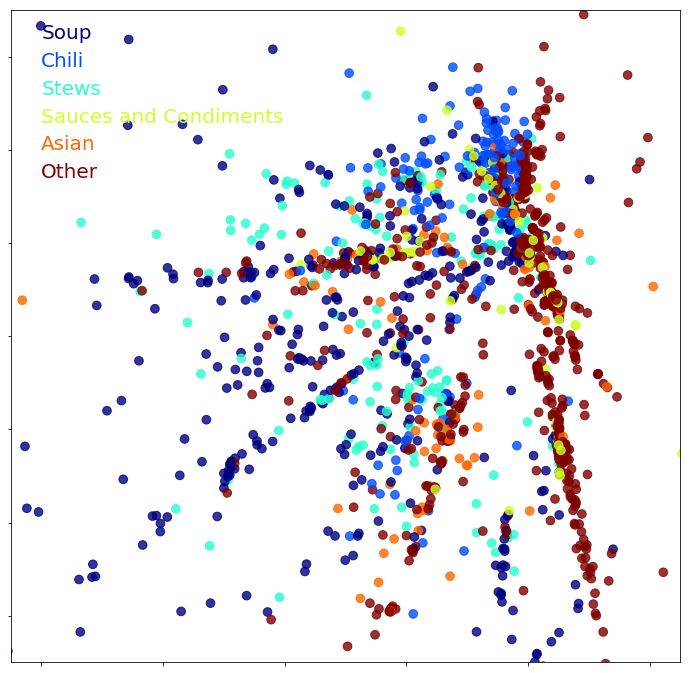

In [67]:
encoder2D = Model(model2.input, model2.get_layer('bottleneck').output)
z_enc = encoder2D.predict(X_scaled)

fig, ax = plt.subplots(1,1,figsize=(12, 12))
mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=colors, s=75, alpha=0.8)
ax.text(-80, 22, common_labels[0], color=cm.jet(0), fontsize=20)
ax.text(-80, 19, common_labels[1], color=cm.jet(1/5), fontsize=20)
ax.text(-80, 16, common_labels[2], color=cm.jet(2/5), fontsize=20)
ax.text(-80, 13, common_labels[3], color=cm.jet(3/5), fontsize=20)
ax.text(-80, 10, common_labels[4], color=cm.jet(4/5), fontsize=20)
ax.text(-80, 7, common_labels[5], color=cm.jet(1.0), fontsize=20)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(left=-85, right=25)
ax.set_ylim(bottom=-45, top=25)

In [31]:
Counter(y).most_common()

[('Soup', 446),
 ('Chili', 222),
 ('Stews', 194),
 ('Sauces and Condiments', 171),
 ('Asian', 129),
 ('Meatloaf', 80),
 ('Pasta', 75),
 ('European', 57),
 ('Pork', 55),
 ('Chicken', 48),
 ('Latin American', 36),
 (None, 31),
 ('Dips and Spreads', 27),
 ('Turkey', 26),
 ('Vegetables', 24),
 ('Shellfish', 18),
 ('Seafood', 17),
 ('Fish', 16),
 ('Beef', 15),
 ('Chowders', 14),
 ('Pasta Salad', 13),
 ('Curries', 10),
 ("Campbell's Kitchen", 9),
 ('Yeast Bread', 9),
 ('Curry Salad', 8),
 ('Vegetable Salads', 8),
 ('Hillshire Farm®', 7),
 ('Potatoes', 7),
 ('Swanson®', 7),
 ('Grains', 7),
 ('Spicy', 7),
 ('Game Meats', 7),
 ('Eggs', 6),
 ('Broth and Stocks', 6),
 ('Vegetable', 6),
 ('Quick Bread', 6),
 ('Reynolds®', 5),
 ('Sandwiches', 5),
 ('Horizon® Organic', 5),
 ('Snacks', 4),
 ("Hunt's", 4),
 ('Meat and Poultry', 4),
 ('Dixie', 4),
 ('Rice', 4),
 ('Specialty Desserts', 4),
 ('Roasts', 4),
 ('Savory Pies', 4),
 ('Barilla', 4),
 ('Breakfast Bread', 4),
 ('Knorr®', 3),
 ('HORMEL Chili', 3)

In [39]:
common_labels = ['Soup','Chili','Stews','Sauces and Condiments','Asian', 'Other']
compressed_labels = [label if label in common_labels else 'Other' for label in y]

In [34]:
len(set(compressed_labels))

6

In [40]:
label_nums = [common_labels.index(label) for label in compressed_labels]

In [42]:
colors = [cm.jet(i/5) for i in label_nums]

In [87]:
n_features = soup_df.shape[1]
soup_model = Sequential()
soup_model.add(Dense(100,  activation='relu', input_shape=(n_features,)))
soup_model.add(Dense(10,  activation='relu'))
soup_model.add(Dense(2,    activation='linear', name="bottleneck"))
soup_model.add(Dense(10,  activation='relu'))
soup_model.add(Dense(100,  activation='relu'))
soup_model.add(Dense(n_features,  activation='linear'))
soup_model.compile(loss='mean_squared_error', optimizer = 'adam')

In [84]:
X = soup_df.values
means = np.mean(soup_df, axis=0)
stds = np.std(soup_df, axis=0)
df_scaled = (soup_df - means) / stds
X_scaled = df_scaled.values

In [106]:
history = soup_model.fit(X_scaled, X_scaled, batch_size=60, epochs=500, verbose=None)

In [94]:
y = create_labels(soup_recipes)
label_names = ['Soup', 'Stews', 'Chili']
label_nums = [label_names.index(label) for label in y]
colors = np.array(['r','g','b'])[label_nums]

No handles with labels found to put in legend.


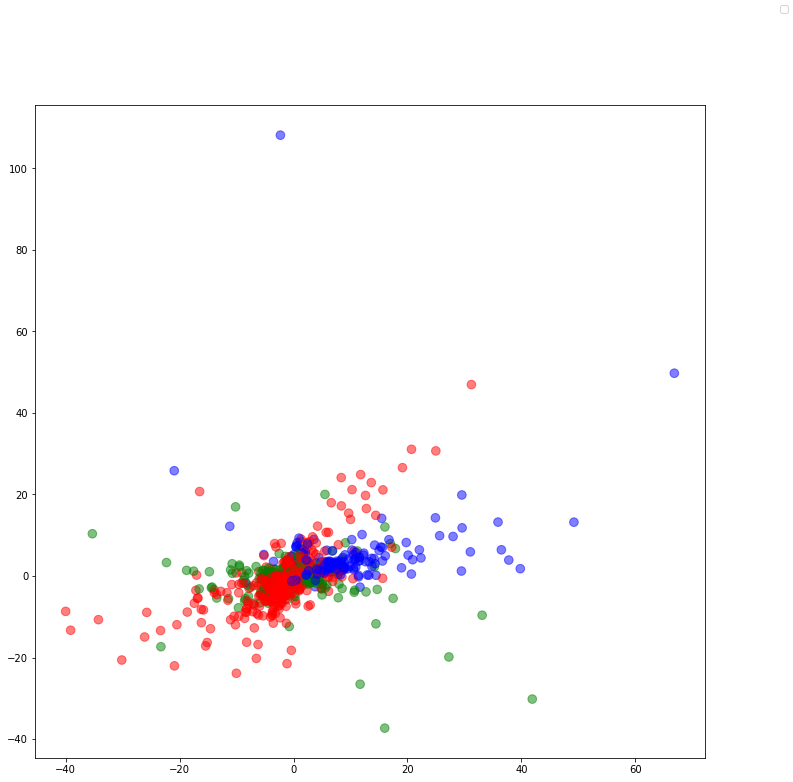

In [99]:
soup_encoder = Model(soup_model.input, soup_model.get_layer('bottleneck').output)
z_enc = soup_encoder.predict(X_scaled)

fig, ax = plt.subplots(1,1,figsize=(12, 12))
mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=colors, s=75, alpha=0.5)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
#ax.set_xlim(left=-85, right=25)
#ax.set_ylim(bottom=-45, top=25)

(-50, 50)

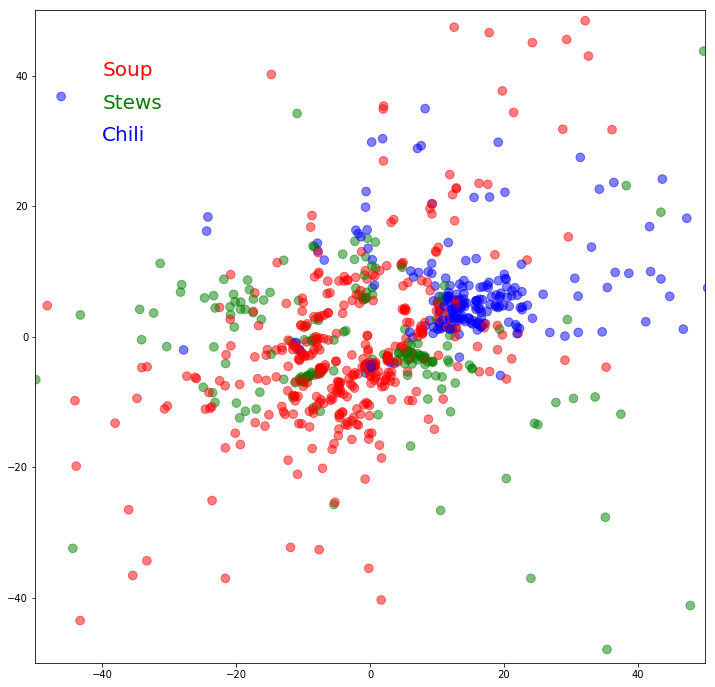

In [109]:
soup_encoder = Model(soup_model.input, soup_model.get_layer('bottleneck').output)
z_enc = soup_encoder.predict(X_scaled)

fig, ax = plt.subplots(1,1,figsize=(12, 12))
mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=colors, s=75, alpha=0.5)
ax.text(-40, 40, label_names[0], color='r', fontsize=20)
ax.text(-40, 35, label_names[1], color='g', fontsize=20)
ax.text(-40, 30, label_names[2], color='b', fontsize=20)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.set_xlim(left=-50, right=50)
ax.set_ylim(bottom=-50, top=50)

In [110]:
history?